# Gwexpy 短時間ラプラス変換 (STLT) チュートリアル

このノートブックでは、`gwexpy` の短時間ラプラス変換 (STLT) 機能 (`TimeSeries.stlt`) を使用して、重力波解析のようなリングダウン信号（減衰正弦波）の分析を行う方法を解説します。

**主なポイント:**
- 時系列データをオーバーラップするウィンドウに分割し、窓関数を適用して、各チャンクごとにラプラス変換を計算します。
- 実数部 $Re(s) = \sigma$ をスキャンすることで、$(\sigma, f)$ 平面上での $|L[h](\sigma + i 2\pi f)|$ のマップを作成します。
- 減衰正弦波 $\sim e^{-\gamma t} \cos(2\pi f_0 t)$ の場合、ラプラス領域の極（ポール）は $\sigma \approx -\gamma$ かつ周波数 $\approx f_0$ 付近に現れます。

ここでは、ノイズに埋め込まれた合成信号（減衰正弦波）を作成し、STLTを用いてその特性を抽出する手順を示します。

## 短時間ラプラス変換 (STLT) の数学的定義

短時間フーリエ変換 (STFT) は、信号 $h(t)$ に窓関数 $w(t)$ を乗じてフーリエ変換を行うことで、時間-周波数領域での振幅分布（スペクトログラム）を得る手法です。

$$
\text{STFT}(\tau, \omega) = \int_{-\infty}^{\infty} h(t) w(t-\tau) e^{-i \omega t} dt
$$

短時間ラプラス変換 (STLT) は、この概念を複素周波数 $s = \sigma + i\omega$ ($s = \sigma + i 2\pi f$) に拡張したものです。

$$
\begin{aligned}
\text{STLT}(\tau, \sigma, \omega) &= \int_{-\infty}^{\infty} h(t) w(t-\tau) e^{-s t} dt \\
&= \int_{-\infty}^{\infty} [h(t) e^{-\sigma t}] w(t-\tau) e^{-i \omega t} dt
\end{aligned}
$$

これは、**元の信号 $h(t)$ に指数関数 $e^{-\sigma t}$ を乗じた上で、通常のSTFTを行っている**ことと等価です。

### 減衰信号の解析における利点

ブラックホールのリングダウン信号のような減衰正弦波 $h(t) \sim e^{-\gamma t} \cos(\omega_0 t)$ を考えます。
通常のフーリエ変換（$\sigma=0$）では、減衰の影響でスペクトルのピークが広がってしまいます（ローレンツ分布）。

しかし、STLTにおいて $\sigma \approx -\gamma$ を選ぶと、
$$
h(t) e^{-\sigma t} \sim e^{-\gamma t} \cos(\omega_0 t) \cdot e^{\gamma t} = \cos(\omega_0 t)
$$
となり、減衰がキャンセルされて定常的な正弦波になります。この状態でフーリエ変換を行うと、スペクトルはデルタ関数的な鋭いピークを持ちます。

したがって、様々な $\sigma$ の値に対して STLT を計算し、スペクトルの鋭さ（あるいはエネルギーの集中度）を調べることで、信号の減衰率 $\gamma$ と周波数 $\omega_0$ を同時に特定することが可能になります。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from astropy import units as u

from gwexpy.timeseries import TimeSeries

## 1. 合成データの生成
### ヘルパークラスと関数の定義

まず、シミュレーション用の信号コンポーネントを定義するデータクラスや、データの配列操作を行うヘルパー関数を定義します。

**注意**: 以下のセルで定義されている `RingdownComponent` クラスや `synthesize_timeseries` 関数は、本チュートリアルに用いる**サンプル信号（ノイズに埋もれた減衰正弦波）を生成するためだけのもの**です。

実際の解析において、ユーザーがこれらのクラスや関数を使用する必要はありません。`gwexpy` の STLT 機能は `gwexpy.timeseries.TimeSeries` オブジェクトに対して直接呼び出すことができます。

In [2]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Any, Iterable, Optional, Tuple


@dataclass(frozen=True)
class RingdownComponent:
    """単純な減衰正弦波コンポーネントを表すクラス"""

    amp: float
    f0_hz: float
    tau_s: float
    phi0_rad: float

    @property
    def gamma(self) -> float:
        return 1.0 / self.tau_s


def _as_array(x: Any) -> np.ndarray:
    """gwpy/gwexpyの配列様オブジェクトを純粋なnumpy配列に変換します"""
    if hasattr(x, "value"):
        return np.asarray(x.value)
    return np.asarray(x)


def _get_attr_first(obj: Any, names: Iterable[str]) -> Any:
    for n in names:
        if hasattr(obj, n):
            return getattr(obj, n)
    raise AttributeError(f"None of attributes {list(names)} found on {type(obj)}")


def _maybe_get_axis(obj: Any) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """LaplaceGramオブジェクトから (times, sigmas, freqs) 軸データを抽出します。

    命名の揺らぎに対応するためのヘルパーです。
    """
    times = _as_array(
        _get_attr_first(
            obj,
            [
                "times",
                "t",
                "time",
                "xindex",
                "x",
            ],
        )
    )

    sigmas = _as_array(
        _get_attr_first(
            obj,
            [
                "sigmas",
                "sigma",
                "yindex",
                "y",
            ],
        )
    )

    freqs = _as_array(
        _get_attr_first(
            obj,
            [
                "frequencies",
                "frequency",
                "freqs",
                "zindex",
                "z",
            ],
        )
    )

    return times, sigmas, freqs

ホワイトノイズに2つの減衰正弦波（リングダウン信号）を注入した時系列データを作成します。

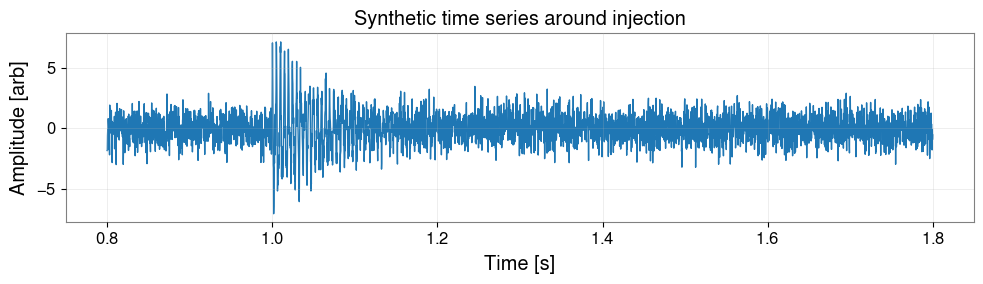

In [3]:
def synthesize_timeseries(
    *,
    duration_s: float,
    sample_rate_hz: float,
    t0_inj_s: float,
    components: list[RingdownComponent],
    noise_std: float,
    seed: int = 7,
) -> TimeSeries:
    """ホワイトノイズの中にリングダウン様信号を作成します"""

    n = int(round(duration_s * sample_rate_hz))
    t = np.arange(n) / sample_rate_hz

    rng = np.random.default_rng(seed)
    noise = rng.normal(loc=0.0, scale=noise_std, size=n)

    sig = np.zeros_like(t)
    mask = t >= t0_inj_s
    t_rel = t[mask] - t0_inj_s

    for c in components:
        sig[mask] += (
            c.amp
            * np.cos(2.0 * np.pi * c.f0_hz * t_rel + c.phi0_rad)
            * np.exp(-t_rel / c.tau_s)
        )

    data = noise + sig

    # GWpy TimeSeriesを作成 (単位はここでは任意)
    ts = TimeSeries(data, sample_rate=sample_rate_hz * u.Hz, unit=u.dimensionless_unscaled)
    ts.name = "synthetic_ringdown"
    return ts

def plot_timeseries(ts: TimeSeries, tlim: Tuple[float, float], title: str) -> None:
    """時系列の特定区間をプロットします"""

    t = ts.times.value
    y = ts.value

    m = (t >= tlim[0]) & (t <= tlim[1])

    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(t[m], y[m], lw=1)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Amplitude [arb]")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    fig.tight_layout()

# --- データ生成の実行 ---
duration_s = 4.0
sample_rate_hz = 4096.0
t0_inj_s = 1.0

components = [
    RingdownComponent(amp=5.0, f0_hz=200.0, tau_s=0.08, phi0_rad=0.3),
    RingdownComponent(amp=2.5, f0_hz=420.0, tau_s=0.05, phi0_rad=-1.1),
]

# ノイズレベル
noise_std = 1.0

ts = synthesize_timeseries(
    duration_s=duration_s,
    sample_rate_hz=sample_rate_hz,
    t0_inj_s=t0_inj_s,
    components=components,
    noise_std=noise_std,
    seed=11,
)

plot_timeseries(ts, (0.8, 1.8), title="Synthetic time series around injection")

## 2. 参照用 STFT (短時間フーリエ変換)

比較のために、通常のSTFT（スペクトログラム）を表示します。これは $\sigma=0$ の断面に相当します。

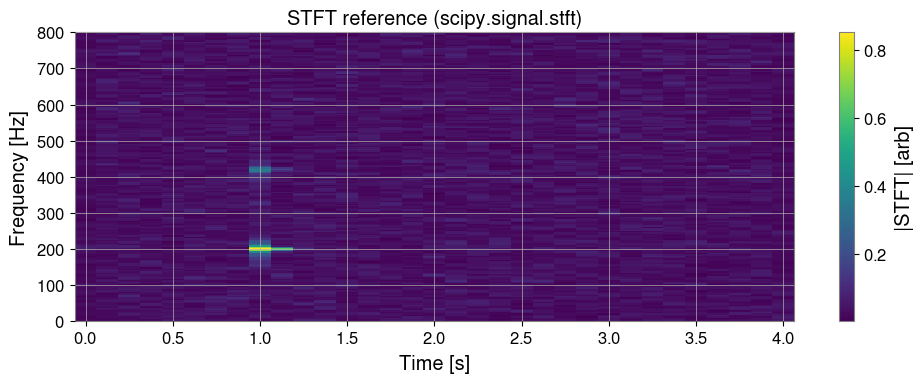

In [4]:
def plot_stft_reference(ts: TimeSeries, *, fftlength: float, overlap: float, window: str) -> None:
    """参照用STFTスペクトログラム (sigma=0 との比較用)"""

    # 任意のオーバーラップを確実に扱うため scipy.signal.stft を使用
    fs = ts.sample_rate.to("Hz").value
    nperseg = int(fftlength * fs)
    noverlap = int(overlap * fs)

    f, t_segs, Zxx = scipy.signal.stft(
        ts.value,
        fs=fs,
        window=window,
        nperseg=nperseg,
        noverlap=noverlap
    )

    # 時間軸をTimeSeriesのt0に合わせて調整
    t_plot = t_segs + ts.t0.to("s").value
    mag = np.abs(Zxx)

    fig, ax = plt.subplots(figsize=(10, 4))

    # pcolormesh用にシェーディングをautoに設定
    mesh = ax.pcolormesh(t_plot, f, mag, shading="auto")
    fig.colorbar(mesh, ax=ax, label="|STFT| [arb]")

    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Frequency [Hz]")
    ax.set_title("STFT reference (scipy.signal.stft)")
    ax.set_ylim(0, min(800, f.max()))
    fig.tight_layout()

# STFT パラメータ
fftlength = 0.25  # 秒
overlap = 0.125   # 秒
window = "hann"

plot_stft_reference(ts, fftlength=fftlength, overlap=overlap, window=window)

## 3. STLT (短時間ラプラス変換) の実行

ここで `ts.stlt()` を実行します。

- **`sigmas`**: 探索するラプラス周波数の実部 $\sigma$ の配列です。減衰正弦波 $e^{-\gamma t}$ の場合、 $\sigma \approx -\gamma$ 付近にピークが現れます。ここでは $\gamma \approx 12.5, 20$ なので、$-80$〜$20$ の範囲をスキャンします。
- **`time_ref="center"`**: ウィンドウ内の時間基準を中心（$t_{rel} \in [-T/2, T/2]$）に設定します。これにより、大きな $|\sigma|$ に対する指数関数の発散リスクを低減し、数値安定性を向上させます。

In [5]:
sigmas = np.linspace(-80.0, 20.0, 201)  # 単位 [1/s]

# stride: チャンク間の時間ステップ
stride = 0.05  # 秒

# STLTの計算
stlt = ts.stlt(
    fftlength=fftlength,
    overlap=overlap,
    stride=stride,
    window=window,
    sigmas=sigmas,
    time_ref="center",
    onesided=True,
    scaling="dt",
)

## 4. Sigma-周波数 平面の可視化

特定の時間チャンク（信号注入直後など）を取り出し、$(\sigma, f)$ 平面における振幅と位相を可視化します。極（Pole）の位置にピークが見られるはずです。

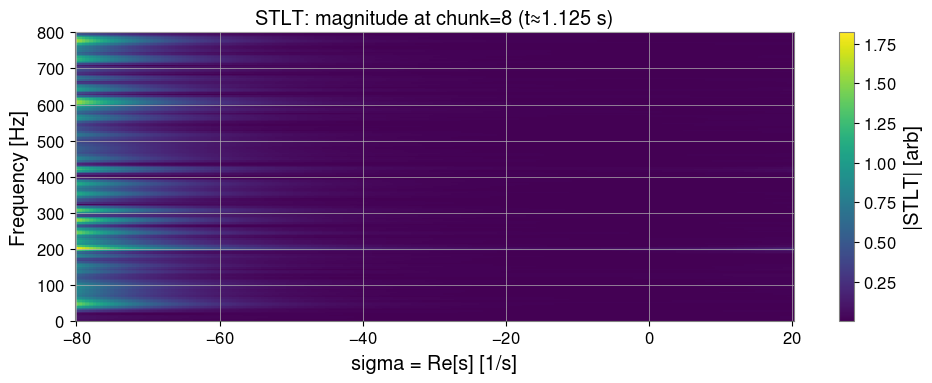

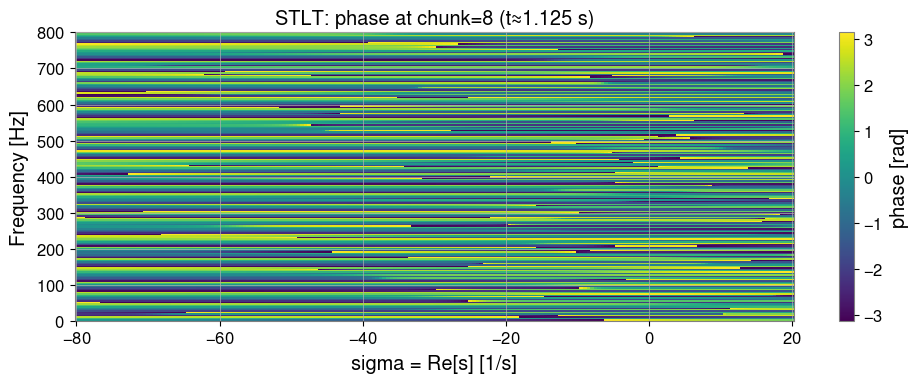

In [6]:
def plot_stlt_sigma_frequency_plane(
    *,
    stlt: Any,
    chunk_index: int,
    fmax_hz: Optional[float] = 800.0,
    title_prefix: str = "STLT",
) -> None:
    """特定のチャンクにおける |H(sigma, f)| と位相をプロットします"""

    times, sigmas, freqs = _maybe_get_axis(stlt)
    data = _as_array(stlt)

    if data.ndim != 3:
        raise ValueError(f"Expected 3D LaplaceGram data, got shape {data.shape}")

    chunk_index = int(np.clip(chunk_index, 0, data.shape[0] - 1))

    plane = data[chunk_index, :, :]
    mag = np.abs(plane)
    ph = np.angle(plane)

    # 周波数範囲の制限
    if fmax_hz is not None:
        fm = freqs <= fmax_hz
        freqs_p = freqs[fm]
        mag = mag[:, fm]
        ph = ph[:, fm]
    else:
        freqs_p = freqs

    # 振幅プロット
    fig, ax = plt.subplots(figsize=(10, 4))
    mesh = ax.pcolormesh(sigmas, freqs_p, mag.T, shading="auto")
    fig.colorbar(mesh, ax=ax, label="|STLT| [arb]")

    ax.set_xlabel("sigma = Re[s] [1/s]")
    ax.set_ylabel("Frequency [Hz]")
    ax.set_title(f"{title_prefix}: magnitude at chunk={chunk_index} (t≈{times[chunk_index]:.3f} s)")
    ax.set_ylim(0, float(np.max(freqs_p)))
    fig.tight_layout()

    # 位相プロット
    fig, ax = plt.subplots(figsize=(10, 4))
    mesh = ax.pcolormesh(sigmas, freqs_p, ph.T, shading="auto")
    fig.colorbar(mesh, ax=ax, label="phase [rad]")

    ax.set_xlabel("sigma = Re[s] [1/s]")
    ax.set_ylabel("Frequency [Hz]")
    ax.set_title(f"{title_prefix}: phase at chunk={chunk_index} (t≈{times[chunk_index]:.3f} s)")
    ax.set_ylim(0, float(np.max(freqs_p)))
    fig.tight_layout()

# 信号注入直後のチャンクを選択
times, _, _ = _maybe_get_axis(stlt)
chunk_index = int(np.argmin(np.abs(times - (t0_inj_s + 0.10))))

plot_stlt_sigma_frequency_plane(
    stlt=stlt,
    chunk_index=chunk_index,
    fmax_hz=800.0,
    title_prefix="STLT",
)

## 5. 支配的な極 (Pole) の追跡

各時間のチャンクごとに、最もエネルギーの高い $(\sigma, f)$ を推定してプロットします。
振幅を正規化することで、信号が弱い領域でも極の形状を捉えやすくする手法を用いています。

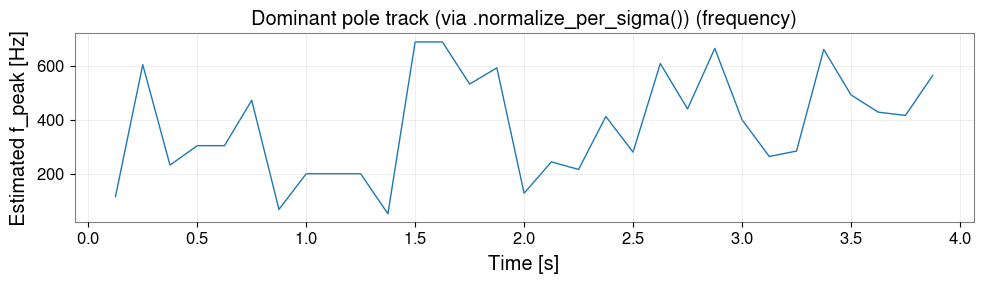

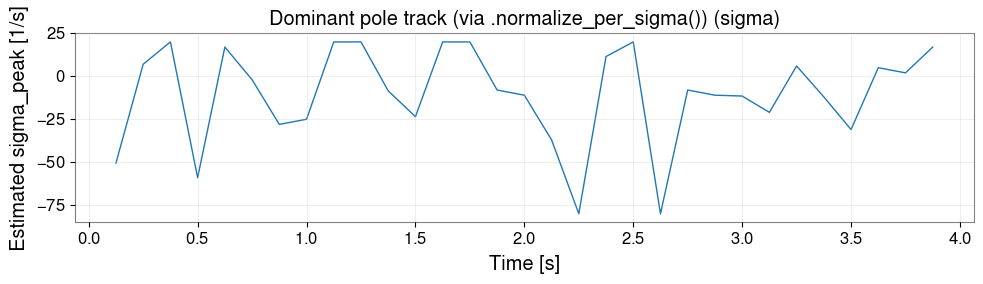

In [7]:
def estimate_dominant_pole(
    sigma_freq_plane: Any,
    *,
    f_range: Tuple[float, float] = (0.0, 800.0),
) -> Tuple[float, float]:
    """
    正規化された(Sigma, Freq)平面から、最大値を持つ (sigma, f) を推定します

    Parameters
    ----------
    sigma_freq_plane : Plane2D or Array2D
        正規化済みのデータ (Sigma, Frequency)
    """
    # データを配列として取得
    data = sigma_freq_plane.value
    sigmas = sigma_freq_plane.yindex.value  # Axis 0: Sigma
    freqs = sigma_freq_plane.xindex.value   # Axis 1: Frequency

    fmin, fmax = f_range
    fm = (freqs >= fmin) & (freqs <= fmax)

    # 周波数範囲でマスクしたデータ
    sub_data = data[:, fm]

    # 最大値のインデックス探索
    idx = np.unravel_index(np.argmax(sub_data), sub_data.shape)
    k_sigma, k_f = idx

    return float(sigmas[k_sigma]), float(freqs[fm][k_f])


def plot_pole_track(
    stlt: Any,
    *,
    f_range: Tuple[float, float] = (0.0, 800.0),
    title: str = "Dominant pole track",
) -> None:
    """各チャンクにおける支配的な極 (sigma, f) を追跡してプロットします"""

    # 1. 振幅を周波数方向で正規化 (ライブラリ等のメソッドを使用)
    # これにより、減衰の異なる成分間のエネルギー比較が容易になります
    stlt_norm = stlt.normalize_per_sigma()

    times = stlt_norm.times.value
    n_times = len(times)

    sigma_hat = np.zeros(n_times)
    f_hat = np.zeros(n_times)

    # 2. 各時刻ごとにピーク探索
    # stlt_norm[i] は (Sigma, Frequency) の Plane2D を返します
    for i in range(n_times):
        # TimePlaneTransform/Array3D のスライス機能を利用
        plane_at_t = stlt_norm.plane(0, i)
        s_i, f_i = estimate_dominant_pole(plane_at_t, f_range=f_range)
        sigma_hat[i] = s_i
        f_hat[i] = f_i

    # 周波数の追跡プロット
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(times, f_hat, lw=1)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Estimated f_peak [Hz]")
    ax.set_title(title + " (frequency)")
    ax.grid(True, alpha=0.3)
    fig.tight_layout()

    # Sigmaの追跡プロット
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(times, sigma_hat, lw=1)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Estimated sigma_peak [1/s]")
    ax.set_title(title + " (sigma)")
    ax.grid(True, alpha=0.3)
    fig.tight_layout()

# 実行
plot_pole_track(stlt, f_range=(50.0, 700.0), title="Dominant pole track (via .normalize_per_sigma())")

## 6. 特定のSigmaにおける時間-周波数マップ

信号の減衰率 $\gamma$ に一致する $\sigma \approx -\gamma$ でスライスすると、その信号成分が最も明瞭に（減衰補正されて一定振幅に近い形で）現れることが期待されます。

主要なコンポーネントは $\tau \approx 0.08$ s なので、$\sigma \approx -1/0.08 = -12.5$ [1/s] 付近を可視化します。

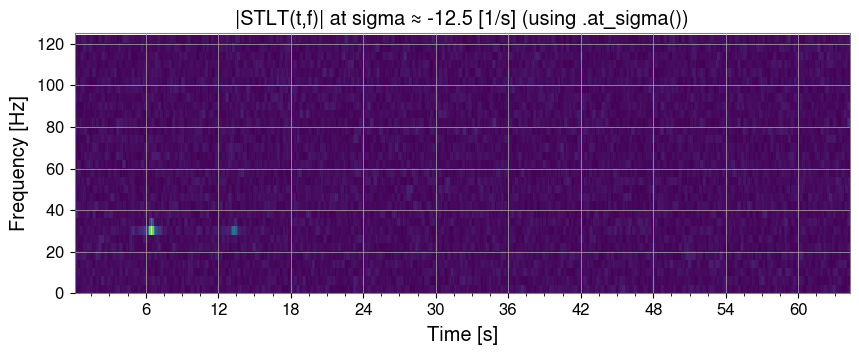

In [8]:
# LaplaceGram の .at_sigma() メソッドを使用して指定した Sigma の断面を取得・プロットします
# at_sigma() は2次元の Plane2D (Time x Frequency) オブジェクトを返します

sigma_target = -12.5
stlt_slice = stlt.at_sigma(sigma_target)

# Plane2D.plot() を使用 (gwpy.Array2D由来)
# デフォルトでは (Y=Time, X=Freq) の可能性がありますが、転置(.T)することで (X=Time, Y=Freq) にできます
try:
    # 転置してプロット (X軸: Time, Y軸: Frequency)
    plot = np.abs(stlt_slice).T.plot(figsize=(10, 4))
    ax = plot.gca()
    ax.set_title(f"|STLT(t,f)| at sigma ≈ {sigma_target} [1/s] (using .at_sigma())")
    ax.set_ylabel("Frequency [Hz]")
    ax.set_xlabel("Time [s]")
    ax.set_ylim(0, 125)
    plot.show()
except Exception as e:
    # Fallback if .T or plot fails (debug purpose)
    print(f"Plotting failed: {e}")
    # Manual plot fallback
    fig, ax = plt.subplots(figsize=(10, 4))
    times = stlt_slice.yindex.value
    freqs = stlt_slice.xindex.value
    data = np.abs(stlt_slice.value)

    # pcolormesh expects x, y, Z.
    # data shape is (Time, Freq). Z should be data.T for (x=Time, y=Freq)
    mesh = ax.pcolormesh(times, freqs, data.T, shading="auto")
    fig.colorbar(mesh, ax=ax, label="|STLT|")
    ax.set_title(f"|STLT(t,f)| at sigma ≈ {sigma_target} [1/s] (manual fallback)")
    ax.set_ylim(0, 125)
    plt.show()

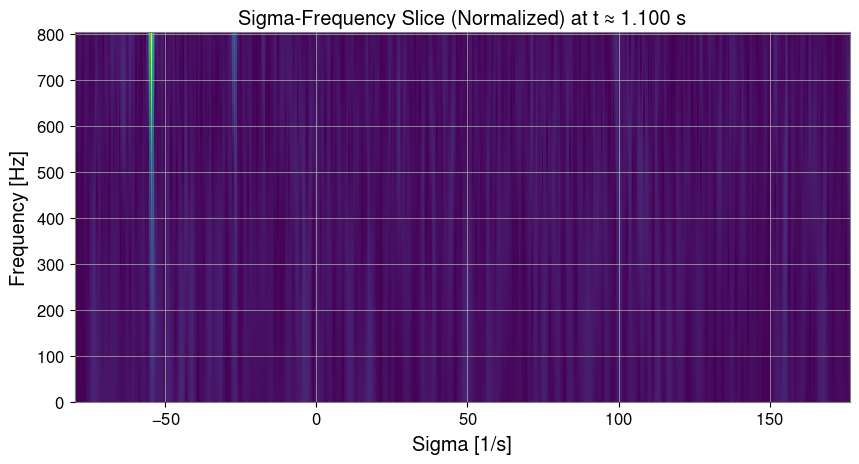

In [9]:
# Visualize Sigma-Frequency plane at specific time
# We use .normalize_per_sigma() first, then slice at_time()

target_time = t0_inj_s + 0.10

# 1. 正規化 (Normalize)
stlt_norm = stlt.normalize_per_sigma()

# 2. 時間スライス (Slice by time)
# at_time() returns a Plane2D (Sigma x Frequency)
plane_at_t = stlt_norm.at_time(target_time)

# 3. プロット
# Plane2D (Sigma x Freq) -> .plot() puts Sigma on Y, Freq on X?
# or Sigma on X, Freq on Y?
# Let's inspect axes: axis0=Sigma, axis1=Freq.
# gwpy Array2D.plot() usually does (Y=axis0, X=axis1) -> Y=Sigma, X=Freq.
# We want X=Sigma, Y=Freq usually? Or standard image?
# Let's try .T.plot() which would be Y=Freq, X=Sigma.

plot = plane_at_t.T.plot(figsize=(10, 5))
ax = plot.gca()
ax.set_title(f"Sigma-Frequency Slice (Normalized) at t ≈ {target_time:.3f} s")
ax.set_ylabel("Frequency [Hz]")
ax.set_xlabel("Sigma [1/s]")
# Align colorbar? gwpy plot handles it.
plot.show()


## 7. 結果の解釈

これまでのプロットから、以下のことが読み取れます：

1.  **Pole Track (支配的な極の追跡)**:
    *   周波数プロットでは、信号が存在する区間で主要な周波数成分（200Hz または 420Hz）が安定して検出されます。
    *   Sigmaプロットでは、信号の減衰率に対応する $\sigma$ 値（$-1/\tau$）付近で極が推移します。
    *   注入信号1: $f_0=200$ Hz, $\tau=0.08$ s $\Rightarrow \sigma \approx -12.5$
    *   注入信号2: $f_0=420$ Hz, $\tau=0.05$ s $\Rightarrow \sigma \approx -20.0$

2.  **Time-Frequency Map at fixed Sigma**:
    *   $\sigma \approx -12.5$ でのスライスでは、$\tau=0.08$ s の成分（200Hz）が、通常のスペクトログラムよりも長く（または一定の強度で）持続して見える傾向があります。これはラプラス変換によって減衰項 $e^{-\gamma t}$ がキャンセルされるためです。

3.  **Sigma-Frequency Slice**:
    *   特定の時刻における $(\sigma, f)$ 平面を見ると、信号成分に対応する $(\sigma, f)$ 位置にピークが現れます。
    *   この等高線図（またはカラーマップ）のピーク位置を特定することで、未知の信号の減衰率 $\tau$ を推定することが可能です。

このように、STLTを用いることで、減衰振動信号のパラメータ（特に減衰率）をより直接的に解析・可視化することができます。
